In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle as pkl
from scipy.linalg import sqrtm

In [2]:
plt.rcParams.update({'font.size': 15})

## The plotting handler

In [3]:
def plot_with_errorband(ax,trial_data,indices = None,label='',stepped=False):
    mu = np.mean(trial_data,axis=0)
    std = np.std(trial_data,axis=0)

    if indices is None:
        indices = range(len(mu))
    if stepped:
        mu = np.repeat(mu,2)[1:]
        std = np.repeat(std,2)[1:]
        indices = np.repeat(indices,2)[:-1]
   
    ax.plot(indices,np.array(mu),label=label)
    ax.fill_between(indices,mu+std,mu-std,alpha=0.2)

In [4]:
def cost(Q,hist):
    n_trial = hist.shape[0]
    timesteps = hist.shape[1]
    Q_cost = [hist[i,j].T.dot(Q).dot(hist[i,j]) for i in range(n_trial) for j in range(timesteps)]

    Q_cost = np.array(Q_cost).reshape(n_trial,timesteps)
    return Q_cost

In [5]:
def expected_cost(M):
    x_dim = M.shape[-1]
    u_dim = M.shape[-2]

    # A_pow[n] = A^n, A_pow[0:H]
    AK_pow = [np.eye(x_dim)]
    for i in range(H):
        AK_pow.append(AK_pow[-1].dot(AK))

    # print('A_pow',A_pow)
    # Express Transition Kernel Phi
    Phi = []

    for k in range(2*H):
        if k<H:
            Phi_k = AK_pow[k]
        else:
            Phi_k = 0

        for i in range(H):
            if 0<= k-i-1 and k-i-1<H:
                Phi_k += AK_pow[i].dot(B).dot(M[k-i-1])
        Phi.append(Phi_k)


    R_sqrt = sqrtm(R)
    Q_sqrt = sqrtm(Q)
    w_sqrt = sqrtm(w_cov)

    R_loss = np.sum(
        [np.linalg.norm(R_sqrt.dot( (M[k]-K_stab).dot(Phi[k]) ).dot(w_sqrt),'fro')**2 for k in range(H)]\
        +[np.linalg.norm(R_sqrt.dot( K_stab.dot(Phi[k]) ).dot(w_sqrt),'fro')**2 for k in range(H,2*H)])

    # The Q loss
    Q_loss = np.sum([np.linalg.norm(Q_sqrt.dot(Phi[k]).dot(w_sqrt),'fro')**2 for k in range(2*H)])
    
    return R_loss+Q_loss

# Total LQR Cost vs $\bar{\eta}$

In [6]:
etas = [1e-4,1e-3,1e-2,0.05,0.1]
# etas = [0.1]
# etas = [0.1,0.2,0.5,1.0]
# etas = [0.01]
control_alg = ['SafeLearning_eta_{}'.format(eta) for eta in etas] + ['ConstrainedDAP']

name_to_eta ={'SafeLearning_eta_{}'.format(eta) : eta for eta in etas}

In [7]:
data = {}
  
costs = {alg:[] for alg in control_alg}
expected_costs = {alg:[] for alg in control_alg}
with open('./data/Parameters.pkl','rb') as f:
    data['Parameters'] = pkl.load(f)

Q = data['Parameters']['Q']
R = data['Parameters']['R']
AK = data['Parameters']['AK']
K_stab = data['Parameters']['K_stab']

A = data['Parameters']['A']
B = data['Parameters']['B']
H = data['Parameters']['H']
w_cov = data['Parameters']['w_cov']


for alg in control_alg:

    with open('./data/{}.pkl'.format(alg),'rb') as f:
        data[alg] = pkl.load(f)

    x_hist = np.array([d['x'] for d in data[alg]])
    u_hist = np.array([d['u'] for d in data[alg]])
    
    M_hist = np.array([d['M'] for d in data[alg]])
    
    print(M_hist.shape)
    if len(M_hist.shape)==4:
        expected_costs[alg] = np.mean([expected_cost(M_hist[i,:,:,:]) for i in range(len(M_hist))])
    else:
        expected_costs[alg] = np.array([[expected_cost(M_hist[i,j,:,:,:]) for j in range(M_hist.shape[1])] for i in range(M_hist.shape[0])])
    print(alg,np.sum(cost(Q,x_hist)),np.sum(cost(R,u_hist[:,:,np.newaxis,np.newaxis])))
    costs[alg] = cost(Q,x_hist)+cost(R,u_hist[:,:,np.newaxis,np.newaxis])      



(20, 9, 6, 1, 2)
SafeLearning_eta_0.0001 1097.2904802868325 139.85625852818254
(20, 9, 6, 1, 2)
SafeLearning_eta_0.001 1059.5952363235035 132.55503423803506
(20, 9, 6, 1, 2)
SafeLearning_eta_0.01 1078.702694916372 137.5980845353453
(20, 9, 6, 1, 2)
SafeLearning_eta_0.05 1099.8194000102603 141.56545709869096
(20, 9, 6, 1, 2)
SafeLearning_eta_0.1 1165.7692453440286 166.33664221804094
(3, 6, 1, 2)
ConstrainedDAP 139.09049412567555 3.8014620435315383


In [8]:
data['Parameters']

{'Q': array([[1, 0],
        [0, 1]]),
 'R': array([[1.]]),
 'D_x': array([[ 1.,  0.],
        [ 0.,  1.],
        [-1., -0.],
        [-0., -1.]]),
 'd_x': array([5, 2, 1, 2]),
 'D_u': array([[ 1.],
        [-1.]]),
 'd_u': array([5. , 9.8]),
 'w_cov': array([[0.04, 0.  ],
        [0.  , 0.04]]),
 'alpha_limit': (0.5, 1.2),
 'beta_limit': (0.2, 0.4),
 'H': 6,
 'H_benchmark': 6,
 'eta_bars': [0.0001, 0.001, 0.01, 0.05, 0.1],
 'A': array([[1.  , 1.  ],
        [0.  , 0.75]]),
 'AK': array([[ 1.        ,  1.        ],
        [-0.66666667, -0.25      ]]),
 'B': array([[0.],
        [1.]]),
 'A_hat_0': array([[1. , 1. ],
        [0. , 0.6]]),
 'B_hat_0': array([[0. ],
        [0.5]]),
 'r_0': 0.2,
 'w_max': 0.2,
 'K_stab': array([[0.66666667, 1.        ]]),
 'l': 0.25,
 'm': 1,
 'dt': 1}

# Expect Regret vs t

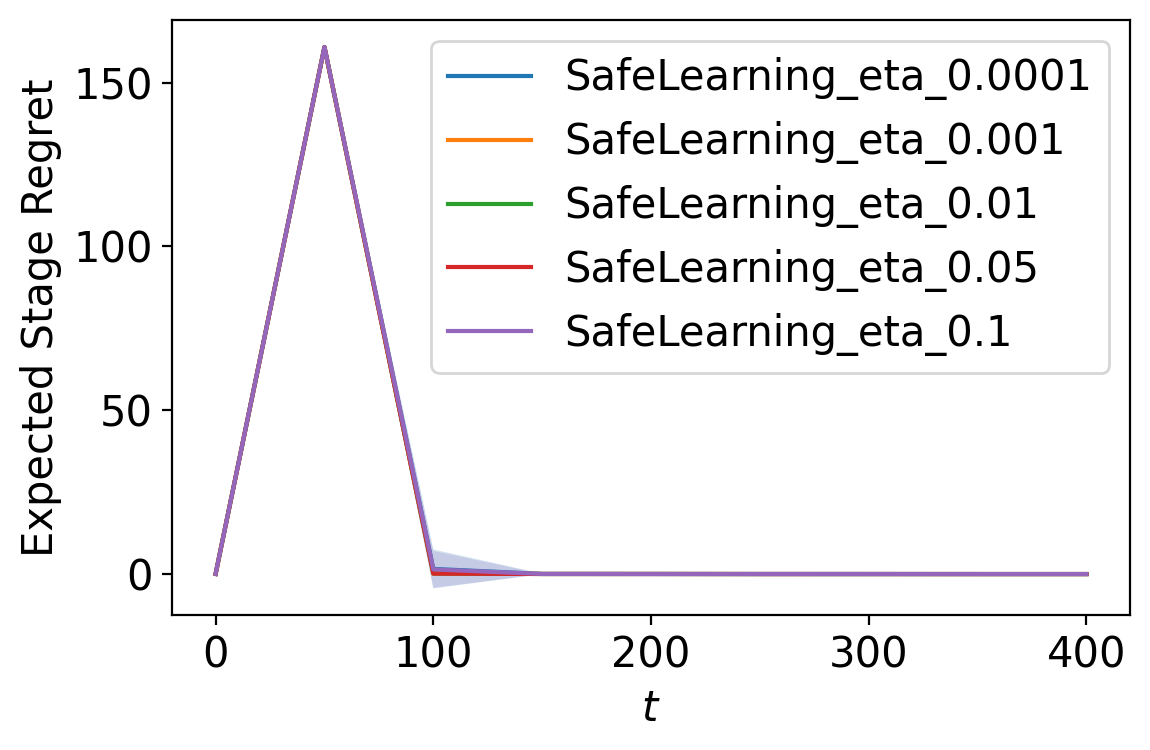

In [9]:
plt.figure(dpi=200)
ax = plt.gca()
for key,item in expected_costs.items():

#     plot_with_errorband(ax,item,label=key)
    if key!='ConstrainedDAP':
  
        
        plot_with_errorband(ax,item-expected_costs['ConstrainedDAP'],indices = np.arange(item.shape[1])*50,label=key)
        
#         print(item-expected_costs['ConstrainedDAP'])
        ax.set_ylabel('Expected Stage Regret')
        ax.set_xlabel(r'$t$')
        ax.legend()
#         ax.set_yscale('log')

plt.tight_layout()
# plt.savefig('./figures/ExpectedStageRegret.png')
plt.show()



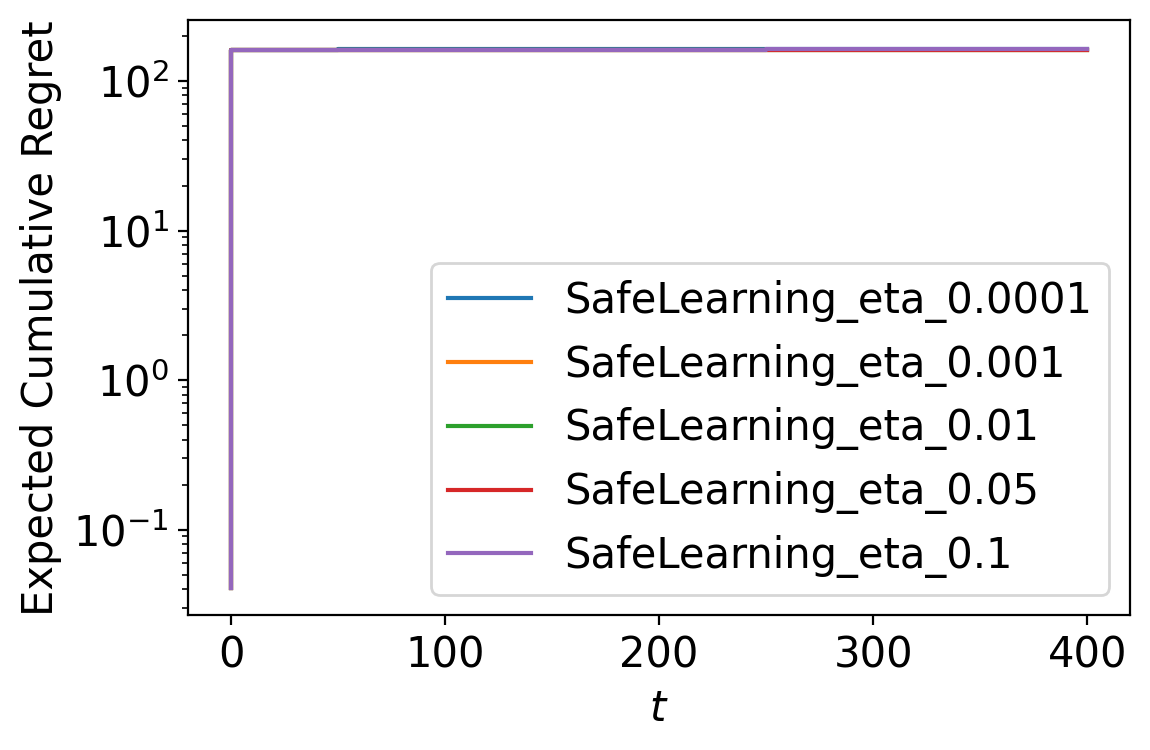

In [10]:
plt.figure(dpi=200)
ax = plt.gca()
for key,item in expected_costs.items():
#     plot_with_errorband(ax,item,label=key)
    if key!='ConstrainedDAP':
        plot_with_errorband(ax,np.cumsum(item-expected_costs['ConstrainedDAP'],axis=-1),indices = np.arange(item.shape[1])*50,label=key,stepped=True)
        ax.set_yscale('log')
ax.set_ylabel('Expected Cumulative Regret')
ax.set_xlabel(r'$t$')
ax.legend()

plt.tight_layout()
plt.savefig('./figures/ExpectedCumuRegret.png')
plt.show()



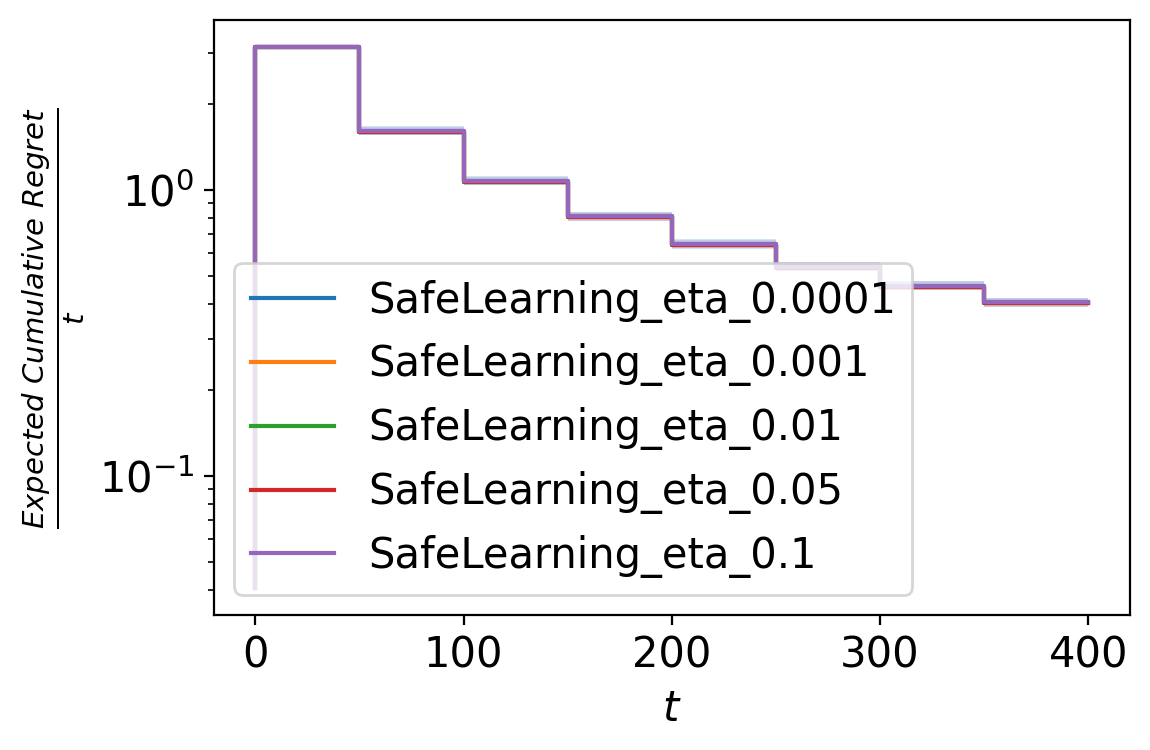

In [11]:
plt.figure(dpi=200)
ax = plt.gca()
for key,item in expected_costs.items():
#     plot_with_errorband(ax,item,label=key)
    if key!='ConstrainedDAP':
        indices = np.arange(item.shape[1])*50
        plot_with_errorband(ax,np.cumsum(item-expected_costs['ConstrainedDAP'],axis=-1)/(indices+1),indices = indices,label=key,stepped=True)
        ax.set_yscale('log')
ax.set_ylabel(r'$\frac{Expected~Cumulative~Regret}{t}$')
ax.set_xlabel(r'$t$')
ax.legend()

plt.tight_layout()
plt.savefig('./figures/ExpectedAveRegret.png')
plt.show()



## LQR Stage Regret vs $t$

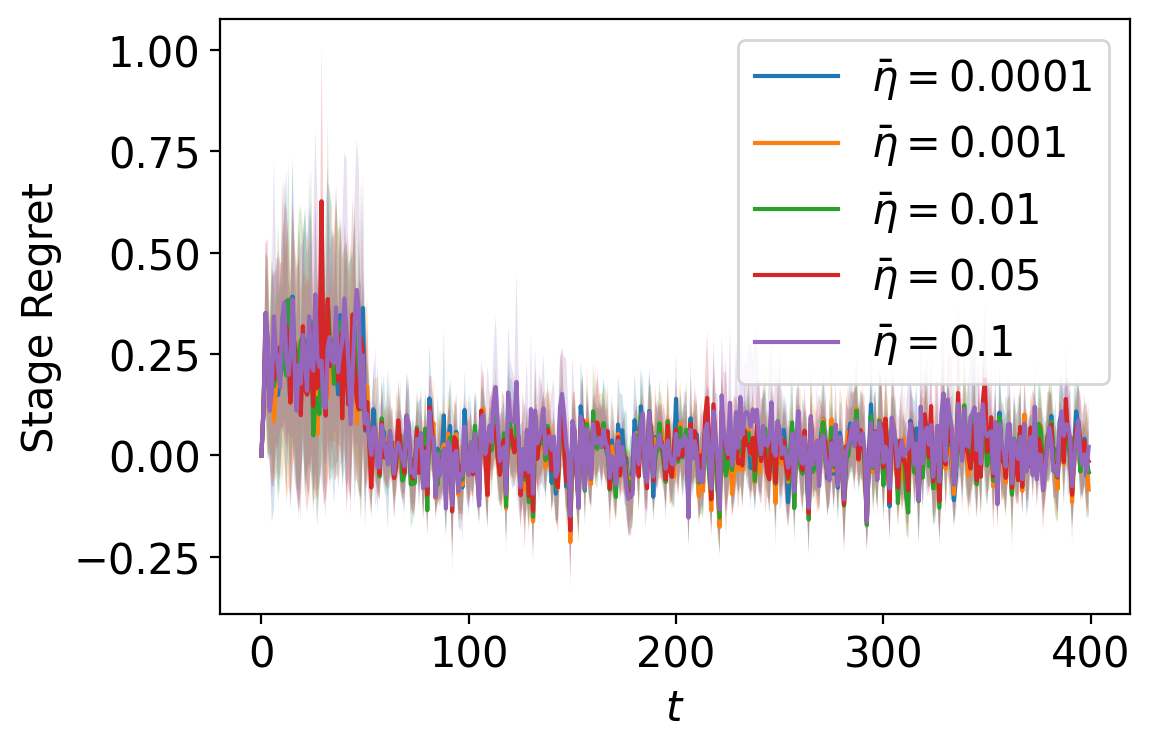

In [12]:
plt.figure(dpi=200)
ax = plt.gca()
for key,item in costs.items():
#     plot_with_errorband(ax,item,label=key)
    if key!='ConstrainedDAP':
        plot_with_errorband(ax,item-np.mean(costs['ConstrainedDAP'],axis=0),label=r'$\bar\eta=${}'.format(name_to_eta[key]))

ax.set_ylabel('Stage Regret')
ax.set_xlabel(r'$t$')
ax.legend()

plt.tight_layout()
plt.savefig('./figures/StageRegret.png')
plt.show()



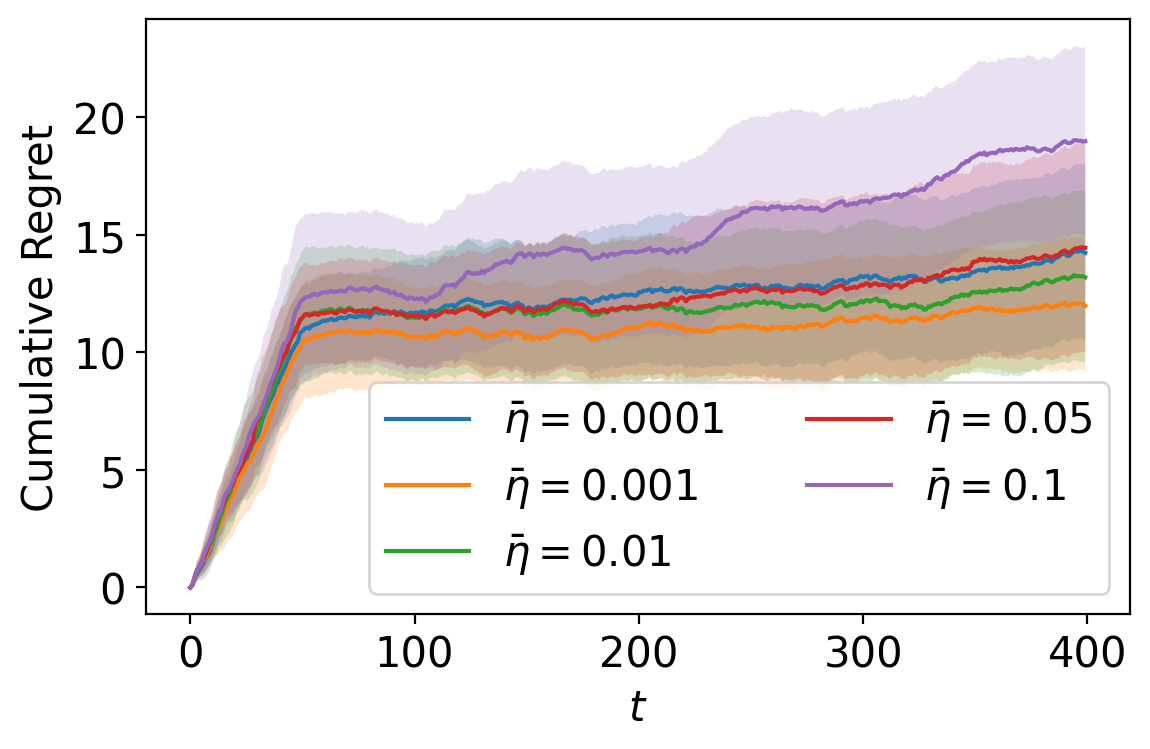

In [13]:
plt.figure(dpi=200)
ax = plt.gca()
for key,item in costs.items():
#     plot_with_errorband(ax,item,label=key)
    if key!='ConstrainedDAP':
        plot_with_errorband(ax,np.cumsum(item-np.mean(costs['ConstrainedDAP'],axis=0),axis=-1),label=r'$\bar\eta=${}'.format(name_to_eta[key]))

ax.set_ylabel('Cumulative Regret')
ax.set_xlabel(r'$t$')
ax.legend(ncol=2)

plt.tight_layout()
plt.savefig('./figures/CumulativeRegret.png')
plt.show()

In [14]:
np.max(np.abs(np.linalg.eigvals(AK)))**5

0.11206549034164988

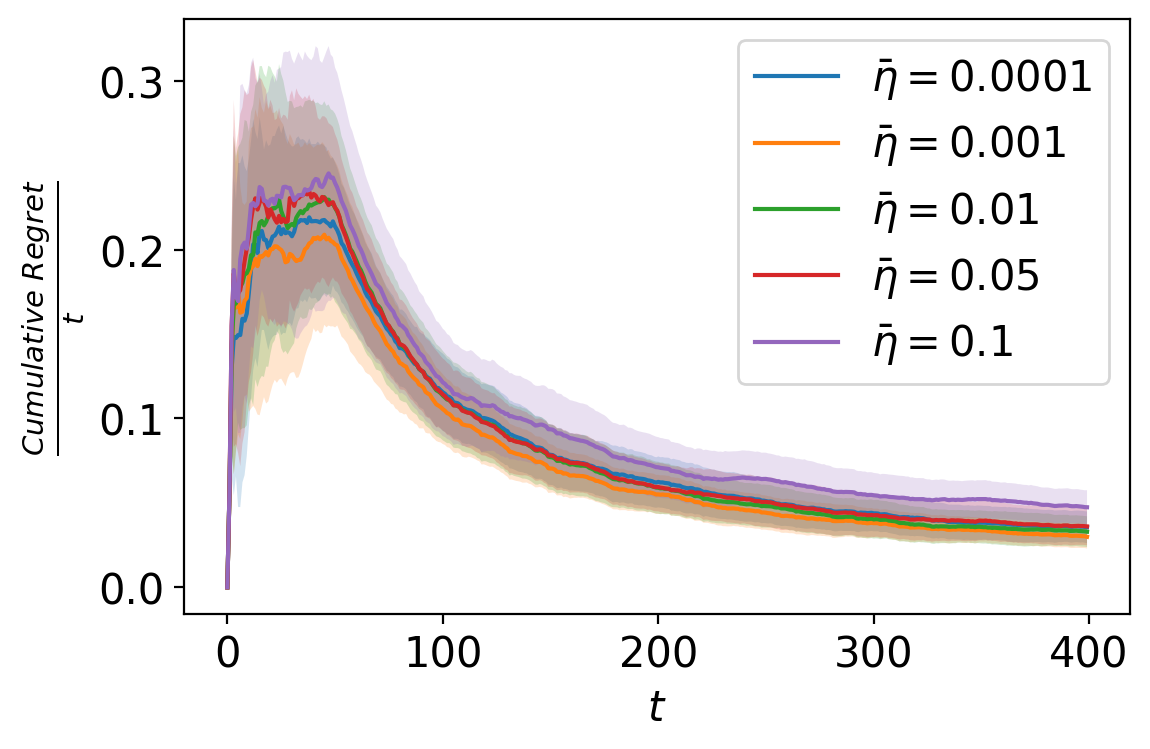

In [15]:
plt.figure(dpi=200)
ax = plt.gca()

for key,item in costs.items():
#     plot_with_errorband(ax,item,label=key)
    if key!='ConstrainedDAP':
        times = np.arange(item.shape[1])+1
        plot_with_errorband(ax,np.cumsum(item-np.mean(costs['ConstrainedDAP'],axis=0),axis=-1)/times,label=r'$\bar\eta=${}'.format(name_to_eta[key]))


ax.set_ylabel(r'$\frac{Cumulative~Regret}{t}$')
ax.set_xlabel(r'$t$')
ax.legend()
plt.tight_layout()
plt.savefig('./figures/AveCumulativeRegret.png')
plt.show()

## Estimation error vs t.

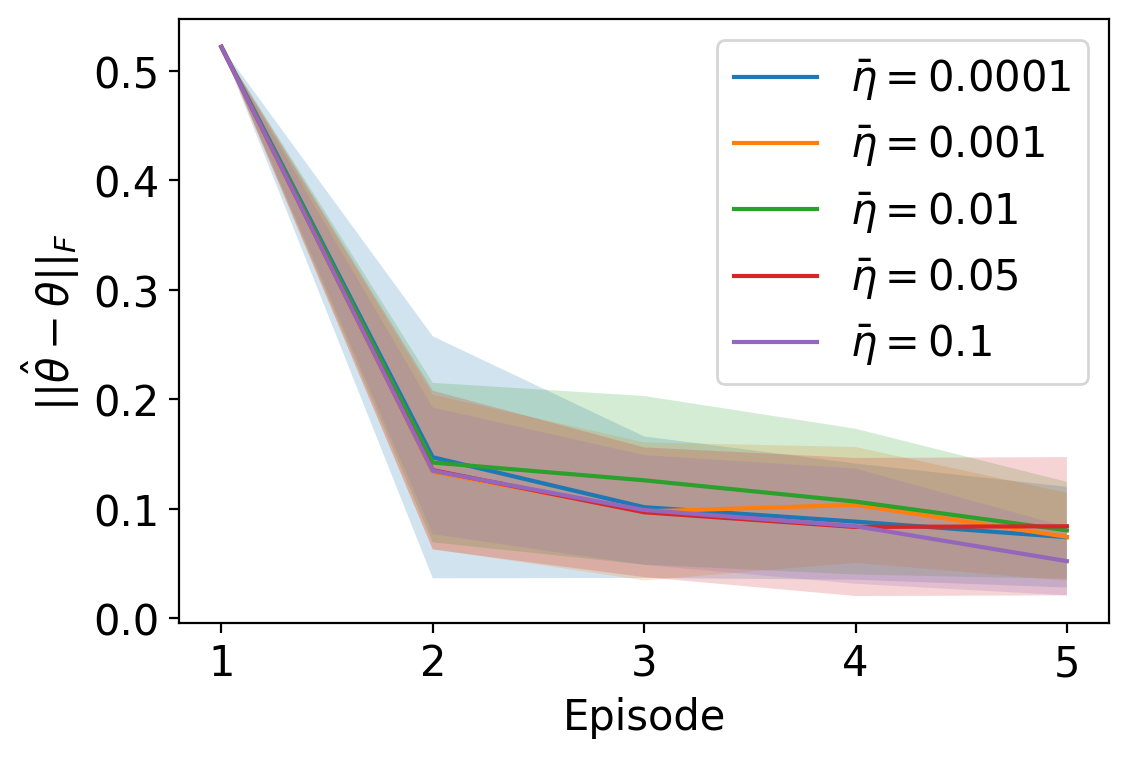

In [17]:

plt.figure(dpi=200)
ax = plt.gca()
for key,item in data.items():
    
    if key!='ConstrainedDAP' and key!='Parameters':

        
        thetas = [d['theta'] for d in item]

        As = np.array([[t[0] for t in theta_hist] for theta_hist in thetas])
        Bs = np.array([[t[1] for t in theta_hist] for theta_hist in thetas])
#         print(As[-1],Bs[-1])
        # As.shape = (# trials, # refits, x_dim, x_dim)
        # Bs.shape = (# trials, # refits, x_dim, u_dim)

        A_diff = np.linalg.norm(As-A,'fro',axis=(-1,-2))
        B_diff = np.linalg.norm(Bs-B,'fro',axis=(-1,-2))
        theta_diff = np.sqrt(A_diff**2+B_diff**2)
        
        
        
        plot_with_errorband(ax,theta_diff,1+np.arange(theta_diff.shape[1],),label=r'$\bar\eta=${}'.format(name_to_eta[key]))
# ax.set_yscale('log')
ax.set_xticks(range(1,theta_diff.shape[1]+1))
ax.set_ylabel(r'$||\hat{\theta}-\theta||_F$')
ax.set_xlabel(r'Episode')
ax.legend()

plt.savefig('./figures/EstimationError.png')
plt.show()

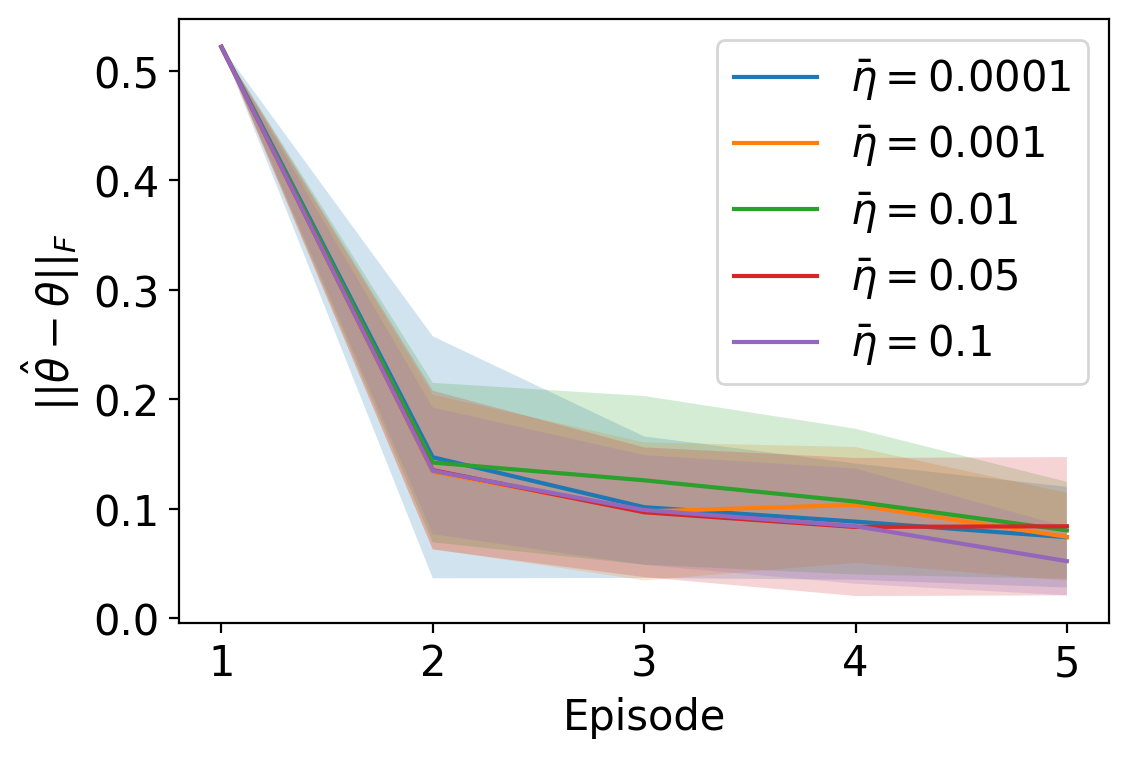

In [17]:

plt.figure(dpi=200)
ax = plt.gca()
for key,item in data.items():
    
    if key!='ConstrainedDAP' and key!='Parameters':

        
        thetas = [d['theta'] for d in item]

        As = np.array([[t[0] for t in theta_hist] for theta_hist in thetas])
        Bs = np.array([[t[1] for t in theta_hist] for theta_hist in thetas])
#         print(As[-1],Bs[-1])
        # As.shape = (# trials, # refits, x_dim, x_dim)
        # Bs.shape = (# trials, # refits, x_dim, u_dim)

        A_diff = np.linalg.norm(As-A,'fro',axis=(-1,-2))
        B_diff = np.linalg.norm(Bs-B,'fro',axis=(-1,-2))
        theta_diff = np.sqrt(A_diff**2+B_diff**2)
        
        
        
        plot_with_errorband(ax,theta_diff,1+np.arange(theta_diff.shape[1],),label=r'$\bar\eta=${}'.format(name_to_eta[key]))
# ax.set_yscale('log')
ax.set_xticks(range(1,theta_diff.shape[1]+1))
ax.set_ylabel(r'$||\hat{\theta}-\theta||_F$')
ax.set_xlabel(r'Episode')
ax.legend()

plt.savefig('./figures/EstimationError.png')
plt.show()

(20, 5)
(20, 5)
(20, 5)
(20, 5)
(20, 5)


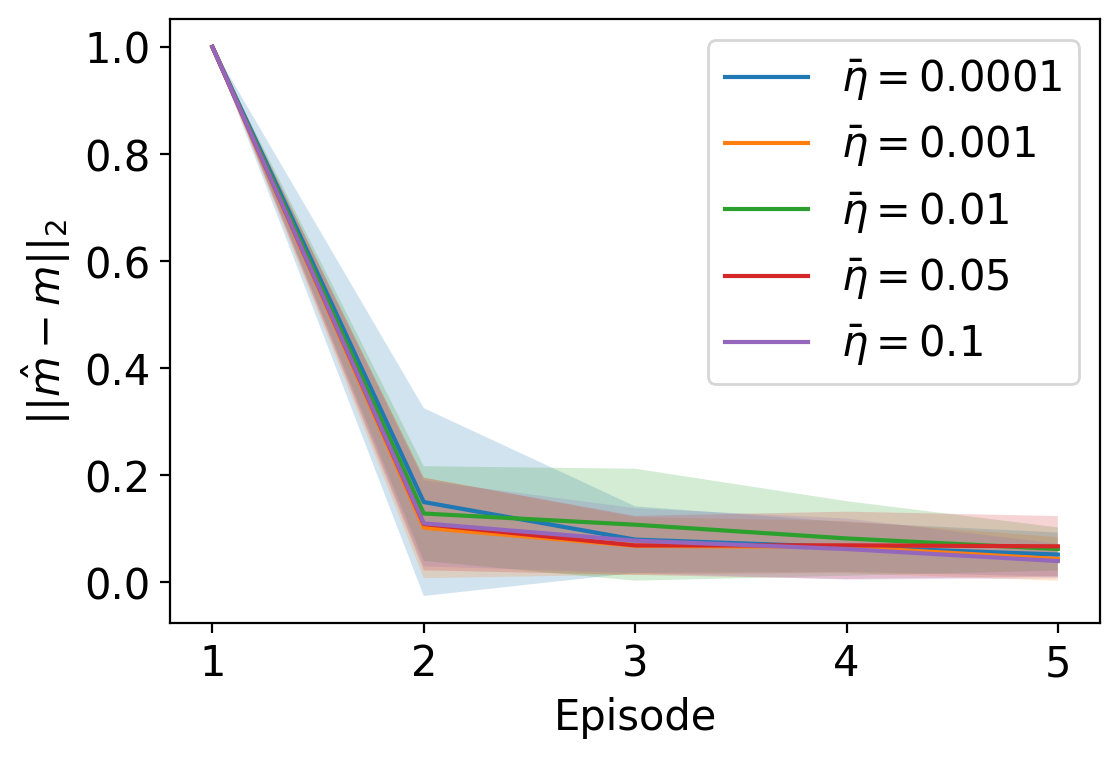

In [57]:

plt.figure(dpi=200)
ax = plt.gca()
dt = data['Parameters']['dt']
m  = data['Parameters']['m']
for key,item in data.items():
    
    if key!='ConstrainedDAP' and key!='Parameters':

        
        thetas = [d['theta'] for d in item]
        
        
        ms = dt/np.array([[t[1][1] for t in theta_hist] for theta_hist in thetas])
#         lm = np.array([[1-t[0][1,1] for t in theta_hist] for theta_hist in thetas])/dt
        
#         print(ms,'ms')
#         print(As[-1],Bs[-1])
        # As.shape = (# trials, # refits, x_dim, x_dim)
        # Bs.shape = (# trials, # refits, x_dim, u_dim)

        m_diff = np.linalg.norm(ms-m,axis=(-1))
#         B_diff = np.linalg.norm(Bs-B,'fro',axis=(-1,-2))
#         theta_diff = np.sqrt(A_diff**2+B_diff**2)
        print(m_diff.shape)
        
        
        
        plot_with_errorband(ax,m_diff,1+np.arange(m_diff.shape[1]),label=r'$\bar\eta=${}'.format(name_to_eta[key]))
# ax.set_yscale('log')
ax.set_xticks(range(1,theta_diff.shape[1]+1))
ax.set_ylabel(r'$||\hat{m}-m||_2$')
ax.set_xlabel(r'Episode')
ax.legend()

plt.savefig('./figures/EstimationError_m.png')
plt.show()

(20, 5)
[[0.4        0.4        0.30921371 0.23078278 0.23618692]
 [0.4        0.2        0.36263264 0.2297194  0.2       ]
 [0.4        0.2        0.2        0.2        0.2       ]
 [0.4        0.4        0.4        0.31689378 0.32264893]
 [0.4        0.2        0.2        0.2        0.2582595 ]
 [0.4        0.2        0.2        0.2221935  0.2509598 ]
 [0.4        0.25013887 0.23923175 0.2        0.2       ]
 [0.4        0.4        0.4        0.4        0.36961487]
 [0.4        0.2        0.26356911 0.3683445  0.4       ]
 [0.4        0.2        0.27354795 0.2        0.2       ]
 [0.4        0.24956629 0.35071996 0.26506315 0.32447692]
 [0.4        0.28604947 0.24543951 0.2        0.26306665]
 [0.4        0.26453354 0.2        0.22378309 0.30169872]
 [0.4        0.2        0.2        0.2        0.2       ]
 [0.4        0.4        0.4        0.4        0.31537233]
 [0.4        0.2        0.2        0.2        0.2       ]
 [0.4        0.4        0.2        0.26559294 0.27357656]
 [0.4 

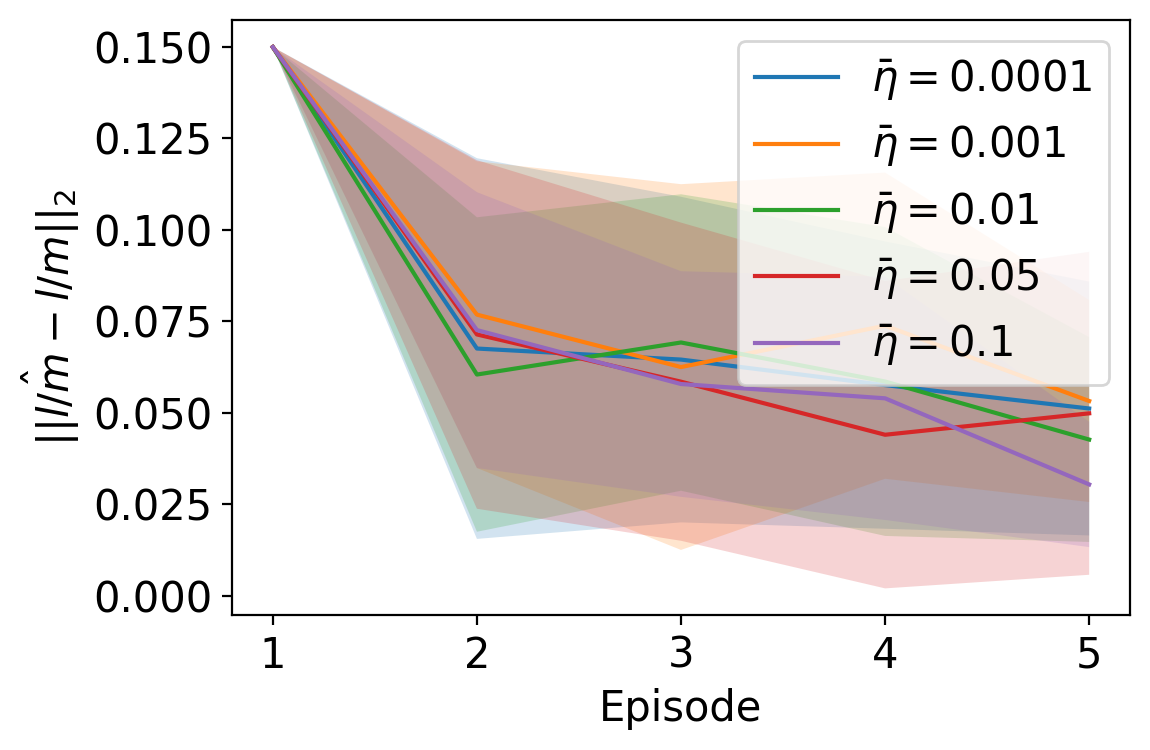

In [59]:

plt.figure(dpi=200)
ax = plt.gca()
dt = data['Parameters']['dt']
m  = data['Parameters']['m']
l = data['Parameters']['l']
for key,item in data.items():
    
    if key!='ConstrainedDAP' and key!='Parameters':

        
        thetas = [d['theta'] for d in item]
        
        
#         ms = dt/np.array([[t[1][1] for t in theta_hist] for theta_hist in thetas])
        lm = np.array([[1-t[0][1,1] for t in theta_hist] for theta_hist in thetas])/dt
        
#         print(ms,'ms')
#         print(As[-1],Bs[-1])
        # As.shape = (# trials, # refits, x_dim, x_dim)
        # Bs.shape = (# trials, # refits, x_dim, u_dim)

        lm_diff = np.abs(lm-l/m)
#         B_diff = np.linalg.norm(Bs-B,'fro',axis=(-1,-2))
#         theta_diff = np.sqrt(A_diff**2+B_diff**2)
        print(lm_diff.shape)
        
        print(lm,l/m)
        
        
        
        plot_with_errorband(ax,lm_diff,1+np.arange(lm_diff.shape[1]),label=r'$\bar\eta=${}'.format(name_to_eta[key]))
# ax.set_yscale('log')
ax.set_xticks(range(1,theta_diff.shape[1]+1))
ax.set_ylabel(r'$||\hat{l/m}-l/m||_2$')
ax.set_xlabel(r'Episode')
ax.legend()

plt.tight_layout()
plt.savefig('./figures/EstimationError_lm.png')
plt.show()

In [19]:
data['Parameters']

{'Q': array([[1, 0],
        [0, 1]]),
 'R': array([[1.]]),
 'D_x': array([[ 1.,  0.],
        [ 0.,  1.],
        [-1., -0.],
        [-0., -1.]]),
 'd_x': array([5, 2, 1, 2]),
 'D_u': array([[ 1.],
        [-1.]]),
 'd_u': array([5. , 9.8]),
 'w_cov': array([[0.04, 0.  ],
        [0.  , 0.04]]),
 'alpha_limit': (0.5, 1.2),
 'beta_limit': (0.2, 0.4),
 'H': 6,
 'H_benchmark': 6,
 'eta_bars': [0.0001, 0.001, 0.01, 0.05, 0.1],
 'A': array([[1.  , 1.  ],
        [0.  , 0.75]]),
 'AK': array([[ 1.        ,  1.        ],
        [-0.66666667, -0.25      ]]),
 'B': array([[0.],
        [1.]]),
 'A_hat_0': array([[1. , 1. ],
        [0. , 0.6]]),
 'B_hat_0': array([[0. ],
        [0.5]]),
 'r_0': 0.2,
 'w_max': 0.2,
 'K_stab': array([[0.66666667, 1.        ]]),
 'l': 0.25,
 'm': 1,
 'dt': 1}